In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
"""Data Loading & Initial Exploration"""
# load the data ( 1000 records for last 30 days)
df = pd.read_csv(r"C:\lsrgc\LittleSteps\data\visits.csv")

In [3]:
# overview of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   visit_id          1000 non-null   object
 1   patient_id        1000 non-null   object
 2   nurse_id          1000 non-null   object
 3   visit_start_time  1000 non-null   object
 4   visit_end_time    900 non-null    object
 5   service_type      1000 non-null   object
 6   visit_location    1000 non-null   object
 7   nurse_notes       900 non-null    object
dtypes: object(8)
memory usage: 62.6+ KB


In [4]:
# preview of first 10 rows
df.head(10)

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
0,6a4a715f-94c5-4b5d-8f51-51f07f298fb6,P59581,N1565,2025-09-02 00:08:24,2025-09-02 00:55:24,Wound Care,East,The nurse changed the wound dressing. The pati...
1,27bfc4de-9dd2-4b6b-b05f-f9560a3fd00f,P66547,N5698,"August 24, 2025 10:42PM","August 25, 2025 12:12AM",General Check-up,East,The nurse reviewed the oxygen level. The patie...
2,9c2d0018-8f20-4789-a383-906d49042fbc,P47919,N3012,2025-09-02 11:07:33,2025/09/02 11:56,Physical Therapy,East,Review is required. The nurse assisted the mob...
3,bbedc08d-0ada-4c8f-bac4-3008ac279a01,P18359,N8991,2025-09-15 21:24:42,2025-09-15 22:12:42,General Check-up,North,Follow-up is required. The nurse reviewed the ...
4,155c3765-22d5-41cc-95f5-a94ef19748ae,P45602,N7948,2025-08-31 07:19:11,2025-08-31 07:47:11,Pyhcisal Therapy,North,ASAP is required. The nurse observed the patie...
5,abeb9a9f-420e-4d33-8a70-081fc43e7499,P42892,N7325,2025-09-06 10:18:14,09/06/2025 11:27,General Check-up,West,The nurse observed the vital signs. The patien...
6,3f579361-69b1-4a84-b30b-3e4b2251bc10,P86548,N9196,2025-08-31 01:13:57,2025-08-31 02:12:57,General Check-up,East,ASAP is required. The nurse observed the tempe...
7,91477f2d-28c8-4ada-b072-02c747eac564,P52180,N1568,09/16/2025 21:22,2025-09-16 21:51:07,General Check-up,West,The nurse observed the vital signs. The patien...
8,2beedf85-2cd0-4f2d-b309-b3bb9131e539,P79973,N3088,09/02/2025 13:53,2025-09-02 15:14:16,Physical Therapy,North,Review is required. The nurse guided the gait ...
9,c10be3fc-63d3-46c9-93c1-6d8814f61954,P66397,N4605,2025-08-31 03:32:13,2025-08-31 03:45:13,General Check-up,South,Review is required. The nurse checked the bloo...


In [5]:
#summary of missing values and duplicates
for col in df.columns:
    sum_na = df[col].isna().sum()
    sum_dups = df[col].duplicated().sum()
    print(f'{col}: has {sum_na} missing values; also {sum_dups} duplicates')

visit_id: has 0 missing values; also 30 duplicates
patient_id: has 0 missing values; also 570 duplicates
nurse_id: has 0 missing values; also 900 duplicates
visit_start_time: has 0 missing values; also 0 duplicates
visit_end_time: has 100 missing values; also 99 duplicates
service_type: has 0 missing values; also 992 duplicates
visit_location: has 0 missing values; also 992 duplicates
nurse_notes: has 100 missing values; also 321 duplicates


In [6]:
# check duplicate visit_end_time
counts = df["visit_end_time"].value_counts(dropna=False)
# print(counts[counts > 1])

In [7]:
#duplicate check, if they are not duplicate entries
# row = df[df["visit_end_time"] == "2025/09/19 20:19"]
# row

In [8]:
#check if same patient_id is paired with the same nurse_id more than once.
df[df.duplicated(subset=["patient_id","nurse_id"], keep=False)]

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
15,f25b6a17-b5eb-444d-964b-cfa7a3b9c0fb,P92552,N3943,2025-08-25 16:48:01,2025-08-25 18:24:01,Medication Administration,East,Monitoring is required. The nurse delivered th...
176,0aeb7cf8-2802-4cd3-8bf8-1a9f6f84949f,P90053,N3933,2025-09-07 20:45:44,2025-09-07 22:21:44,General Chek-up,East,Review is required. The nurse encouraged the g...
192,b8d57d45-6866-4076-8601-07b88a8fcc94,P51682,N7325,2025-09-02 02:28:44,09/02/2025 03:23,Wound Care,North,Follow-up is required. The nurse changed the i...
204,fe5239d8-3fbd-499b-ba02-c7b9caddc9ae,P72592,N7368,2025-09-13 05:31:16,2025-09-13 06:00:16,Physical Therapy,North,The nurse monitored the mobility exercise. The...
333,223ee503-6383-48f9-89d5-cc9d0717d26b,P23065,N6322,2025-09-02 04:11:18,2025-09-02 05:44:18,Medication Administration,South,The nurse delivered the medication. The patien...
523,88eeb4ba-83cf-4074-9bc9-e80ec4e10665,P60761,N4178,2025-08-27 11:54:16,NaN,Physical Therapy,North,Follow-up is required. The nurse guided the mo...
542,b0cb545a-4161-4ffe-97f3-fb88446024ac,P92552,N3943,2025-08-24 16:39:26,2025/08/24 17:33,Medication Administration,South,NaN
550,d5c2c283-6830-4271-a43b-a6c3ac771ea0,P90053,N3933,2025/08/30 19:22,2025-08-30 19:57:22,Physical Therapy,Wsst,The nurse monitored the range of motion. The p...
624,acb46947-d558-4beb-ba3d-a96d87edb490,P14313,N7969,2025-08-23 20:33:01,2025/08/23 21:44,Physical Therapy,East,The nurse guided the range of motion. The pati...
630,733ab5a1-fcc2-434a-9092-0146922c375f,P29486,N3280,2025-08-26 02:36:14,2025/08/26 04:00,Physical Therapy,West,The nurse guided the strength training. The pa...


In [9]:
# check duplicate visit entry
df[df.duplicated(subset=["patient_id","visit_id"], keep=False)]

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes


In [10]:
# check visit count per patient
df.groupby("patient_id")["visit_id"].nunique().describe()

count    430.000000
mean       2.325581
std        1.251962
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: visit_id, dtype: float64

In [11]:
# check how visit distributed and the most visited patient
# probably the location should be at most 2 per client
visit_counts = df.groupby("patient_id")["visit_id"].nunique()
print(visit_counts.value_counts().sort_index())
patients_many_visits = visit_counts[visit_counts == visit_counts.max()].index
df[df["patient_id"].isin(patients_many_visits)]

visit_id
1    132
2    131
3     96
4     50
5     12
6      6
7      2
8      1
Name: count, dtype: int64


,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
132,dd595444-4cfc-4784-abbd-3a9a8cb7261f,P29486,N4983,2025-08-26 19:17:06,2025-08-26 19:45:06,Medication Administration,West,The nurse provided the injection. The patient ...
180,1e257ff4-bdd5-4629-a392-30d0af65d729,P29486,N4881,2025-09-15 20:41:35,2025-09-15 21:34:35,General Check-up,West,NaN
393,1ee5128b-da91-447f-994e-caa134cf6a22,P29486,N4754,2025-08-27 09:47:24,2025-08-27 11:04:24,Medication Administration,East,Critical is required. The nurse administered t...
404,41ba91f9-c219-422f-96ec-fb9e28361ef7,P29486,N7276,2025/09/02 17:55,2025-09-02 19:00:04,Physical Therapy,East,Review is required. The nurse monitored the st...
416,64af17de-fdb8-47a6-a5d4-9e3c7740c559,P29486,N5647,2025-09-12 04:01:21,2025-09-12 05:26:21,Physical Therapy,East,The nurse encouraged the range of motion. The ...
630,733ab5a1-fcc2-434a-9092-0146922c375f,P29486,N3280,2025-08-26 02:36:14,2025/08/26 04:00,Physical Therapy,West,The nurse guided the strength training. The pa...
663,2923ebc2-4de9-46fa-86e5-3d1cabce1fa7,P29486,N3280,2025-09-17 18:36:55,09/17/2025 19:15,Medication Administration,West,The nurse delivered the injection. The patient...
939,c592d08a-072e-4723-a588-cae32010a1ba,P29486,N2804,2025-09-01 18:44:57,2025-09-01 20:18:57,General Check-up,East,The nurse observed the temperature. The patien...


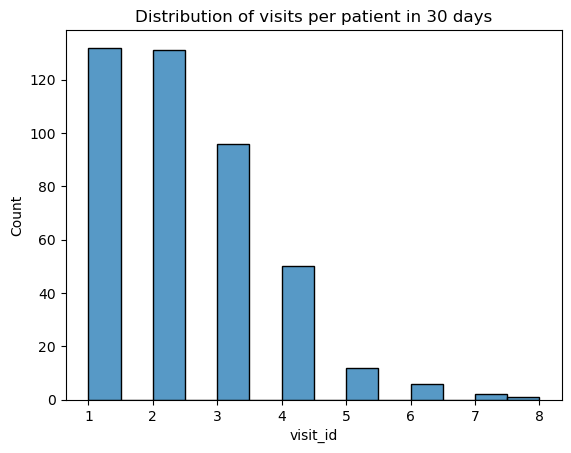

In [12]:
# histgram for the visit per patient
sns.histplot(visit_counts)
plt.title("Distribution of visits per patient in 30 days")
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_histplot_patient.png"),
#             dpi=300, bbox_inches="tight")
plt.show()

In [13]:
# check how visit distributed and the most visited patient
# probably the location should be at most 2 per client
visit_counts = df.groupby("nurse_id")["visit_id"].nunique()
print(visit_counts.value_counts().sort_index())
patients_many_visits = visit_counts[visit_counts == visit_counts.max()].index
df[df["nurse_id"].isin(patients_many_visits)]

visit_id
3      3
4      1
5      2
6      4
7     13
8     13
9     17
10    11
11     8
12     3
13     7
14     6
15     4
16     3
17     3
18     1
19     1
Name: count, dtype: int64


,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
58,ad4250dc-168e-4d8a-9a04-02206152ff17,P30993,N2273,08/24/2025 11:28,NaN,Medicatn Adminstratino,West,The nurse administered the oral dose. The pati...
163,164b1d50-78b8-432c-8adb-19f0fc700d2a,P93308,N2273,2025/09/13 14:29,09/13/2025 15:59,Medicatn Adminstratino,North,The nurse encouraged the strength training. Th...
195,e65e4913-38ef-4957-9625-c5a95d0ae842,P29092,N2273,2025-09-03 23:08:54,09/04/2025 00:34,Physical Therapy,South,Ongoing assessment is required. The nurse moni...
238,c3f24c7e-e345-4cee-9982-29cc493ef7b0,P90140,N2273,2025-08-24 14:14:14,2025-08-24 14:53:14,General Check-up,North,The nurse monitored the blood pressure. The pa...
251,27251e8b-1da6-4728-a3ec-0aafb0320712,P81739,N2273,09/09/2025 12:19,NaN,General Check-up,South,Follow-up is required. The nurse checked the v...
285,78241805-a727-4926-b7be-6e9d89b4e6fd,P88594,N2273,2025/09/11 16:54,2025-09-11 18:11:34,Medication Administration,Wsst,The nurse administered the IV line. The patien...
308,10e3ee38-edf4-4e39-827c-747ad9a8b73f,P15375,N2273,2025-08-30 11:22:42,2025-08-30 11:34:42,Medication Administration,North,NaN
414,9ef7d767-e4a6-4f94-8c9d-9f8ca5c0c346,P50292,N2273,2025-09-11 02:12:40,2025-09-11 03:22:40,Physical Therapy,East,The nurse guided the strength training. The pa...
515,c82f7caa-8824-489c-8ac1-bc437252463f,P70806,N2273,2025-09-16 10:32:32,NaN,Medication Administration,North,NaN
526,dcd4990a-38e3-49e2-a4ee-dc84e80b6dc8,P89305,N2273,2025/08/25 14:14,2025-08-25 16:09:28,Medication Administration,Soutth,NaN


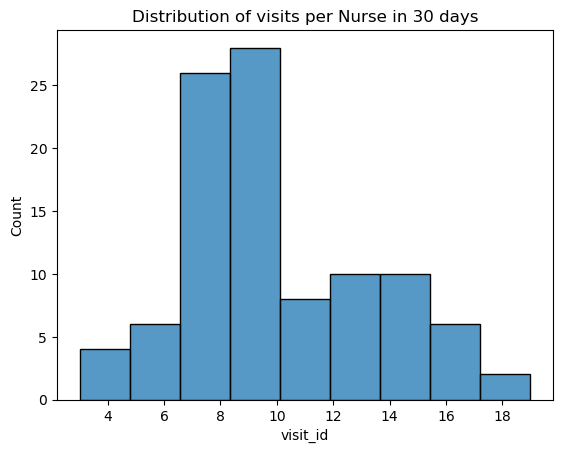

In [14]:
# histgram for the visit per nurse
sns.histplot(visit_counts)
plt.title("Distribution of visits per Nurse in 30 days")
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_histplot_nurse.png"),
#             dpi=300, bbox_inches="tight")
plt.show()

In [15]:
"""Data Cleaning & Preprocessing:"""
# copy the original dataset
from copy import deepcopy
df1 = deepcopy(df)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   visit_id          1000 non-null   object
 1   patient_id        1000 non-null   object
 2   nurse_id          1000 non-null   object
 3   visit_start_time  1000 non-null   object
 4   visit_end_time    900 non-null    object
 5   service_type      1000 non-null   object
 6   visit_location    1000 non-null   object
 7   nurse_notes       900 non-null    object
dtypes: object(8)
memory usage: 62.6+ KB


In [16]:
# quick check if the copy has missing value
df1['visit_start_time'].isna().sum()

0

In [17]:
"""Cleaning 1: Standardize date/time formats"""
df1['visit_start_time'] = df1['visit_start_time'].astype('datetime64[ns]')
df1['visit_end_time'] = df1['visit_end_time'].astype('datetime64[ns]')
df1 = df1.sort_values('visit_start_time')
df1.head()

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
835,1b7b80df-afe3-4b29-9bb5-d50cb995b1a5,P13878,N3681,2025-08-19 12:19:00,2025-08-19 13:46:52,Physical Therapy,West,The nurse guided the strength training. The pa...
837,b16257ff-36be-4bee-91db-51f38c5533e6,P88018,N2340,2025-08-19 14:22:52,2025-08-19 15:02:00,Medication Administration,South,Follow-up is required. The nurse delivered the...
37,55bcc717-ca1e-43e3-a8f5-1c32a49ffff9,P51923,N4957,2025-08-19 17:19:00,2025-08-19 18:01:42,Physical Therapy,South,Monitoring is required. The nurse guided the g...
547,6dd0dedc-ebc9-4f27-a9e9-14389ba40c28,P20227,N4754,2025-08-19 18:03:08,2025-08-19 18:13:08,Wound Care,North,Ongoing assessment is required. The nurse clea...
612,ddd0fb6e-f368-4570-acd3-5f255cbfafd9,P87136,N2044,2025-08-19 18:07:41,2025-08-19 19:04:00,Physical Therapy,East,The nurse guided the strength training. The pa...


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 835 to 122
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   visit_id          1000 non-null   object        
 1   patient_id        1000 non-null   object        
 2   nurse_id          1000 non-null   object        
 3   visit_start_time  1000 non-null   datetime64[ns]
 4   visit_end_time    900 non-null    datetime64[ns]
 5   service_type      1000 non-null   object        
 6   visit_location    1000 non-null   object        
 7   nurse_notes       900 non-null    object        
dtypes: datetime64[ns](2), object(6)
memory usage: 70.3+ KB


In [19]:
""" Clearning 2: Remove duplicate visit_id records."""
df1 =df1.drop_duplicates(subset =['visit_id'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   visit_id          970 non-null    object        
 1   patient_id        970 non-null    object        
 2   nurse_id          970 non-null    object        
 3   visit_start_time  970 non-null    datetime64[ns]
 4   visit_end_time    875 non-null    datetime64[ns]
 5   service_type      970 non-null    object        
 6   visit_location    970 non-null    object        
 7   nurse_notes       874 non-null    object        
dtypes: datetime64[ns](2), object(6)
memory usage: 68.2+ KB


In [20]:
""" Clearning 3: Clean and standardize categorical variables (service_type, visit_location)."""
import re

def regex_replace(series, mapping):
    series = series.astype(str)  # ensure string
    for pattern, replacement in mapping.items():
        series = series.str.replace(pattern, replacement, regex=True, flags=re.IGNORECASE)
    return series

service_type_map = {
    r"m.*a.*": "Medication Administration",
    r"w.*c.*": "Wound Care",
    r"p.*t.*": "Physical Therapy",
    r"g.*c*": "General Check-up"
}
visit_location_map = {
    r"n.*": "North",
    r"s.*": "South",
    r"e.*": "East",
    r"w.*": "West"
}
df1["service_type"]   = regex_replace(df["service_type"], service_type_map)
df1["visit_location"] = regex_replace(df["visit_location"], visit_location_map)

print(df1['service_type'].unique())
print(df1["visit_location"].unique())

['Physical Therapy' 'Medication Administration' 'Wound Care'
 'General Check-up']
['West' 'South' 'North' 'East']


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   visit_id          970 non-null    object        
 1   patient_id        970 non-null    object        
 2   nurse_id          970 non-null    object        
 3   visit_start_time  970 non-null    datetime64[ns]
 4   visit_end_time    875 non-null    datetime64[ns]
 5   service_type      970 non-null    object        
 6   visit_location    970 non-null    object        
 7   nurse_notes       874 non-null    object        
dtypes: datetime64[ns](2), object(6)
memory usage: 68.2+ KB


In [22]:
df1.head()

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes
835,1b7b80df-afe3-4b29-9bb5-d50cb995b1a5,P13878,N3681,2025-08-19 12:19:00,2025-08-19 13:46:52,Physical Therapy,West,The nurse guided the strength training. The pa...
837,b16257ff-36be-4bee-91db-51f38c5533e6,P88018,N2340,2025-08-19 14:22:52,2025-08-19 15:02:00,Medication Administration,South,Follow-up is required. The nurse delivered the...
37,55bcc717-ca1e-43e3-a8f5-1c32a49ffff9,P51923,N4957,2025-08-19 17:19:00,2025-08-19 18:01:42,Physical Therapy,South,Monitoring is required. The nurse guided the g...
547,6dd0dedc-ebc9-4f27-a9e9-14389ba40c28,P20227,N4754,2025-08-19 18:03:08,2025-08-19 18:13:08,Wound Care,North,Ongoing assessment is required. The nurse clea...
612,ddd0fb6e-f368-4570-acd3-5f255cbfafd9,P87136,N2044,2025-08-19 18:07:41,2025-08-19 19:04:00,Physical Therapy,East,The nurse guided the strength training. The pa...


In [23]:
"""Cleaning 4: Handle missing values appropriately (e.g., imputation, deletion, or flagging, with justification)."""
df1.isnull().sum()

visit_id             0
patient_id           0
nurse_id             0
visit_start_time     0
visit_end_time      95
service_type         0
visit_location       0
nurse_notes         96
dtype: int64

In [24]:
"""since mssing values in notes are not critical at this stage,we fill NA to missing notes, and create a flag for futuer quality check"""
# 1 = originally missing, 0 = originally present
df1["nurse_notes_missing"] = df1["nurse_notes"].isna().astype(int)
df1["nurse_notes"]= df1["nurse_notes"].fillna('NA')
df1.isnull().sum()

visit_id                0
patient_id              0
nurse_id                0
visit_start_time        0
visit_end_time         95
service_type            0
visit_location          0
nurse_notes             0
nurse_notes_missing     0
dtype: int64

before imputation
 count     875.000000
mean       85.977448
std       148.830002
min         0.383333
25%        35.000000
50%        64.000000
75%        94.841667
max      1432.883333
Name: duration_min, dtype: float64


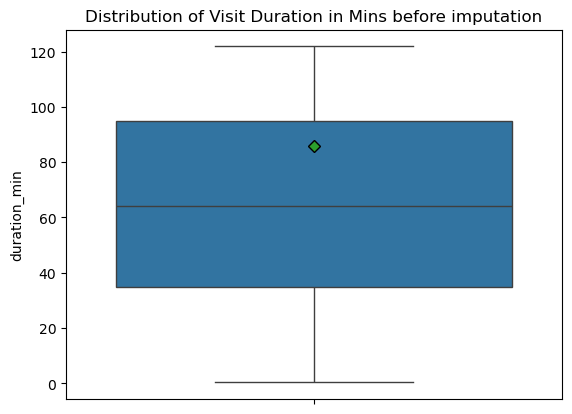

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes,nurse_notes_missing,duration_min


In [25]:
"""For missing end time, we try to impute missing visit_end_time with median duration (robust to outliers) but decide not to impute but flag for further modelling if required."""
# 1 = originally missing, 0 = originally present
df1["duration_min"] = (df1["visit_end_time"] - df1["visit_start_time"]).dt.total_seconds() / 60
print("before imputation\n",df1["duration_min"].describe())

sns.boxplot(df1["duration_min"], showfliers = False, meanprops={"marker":"D","markeredgecolor":"black"}, showmeans = True)
plt.title("Distribution of Visit Duration in Mins before imputation")
plt.show()

# negative duration
df1.loc[df1["duration_min"]<0]

after imputation
 count     970.000000
mean       83.825017
std       141.497281
min         0.383333
25%        39.000000
50%        64.000000
75%        90.766667
max      1432.883333
Name: duration_min, dtype: float64


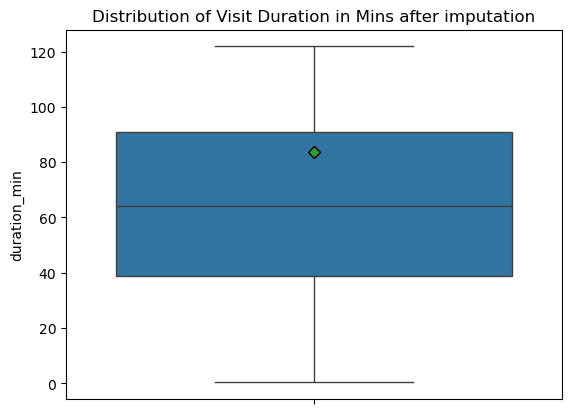

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_id             970 non-null    object        
 1   patient_id           970 non-null    object        
 2   nurse_id             970 non-null    object        
 3   visit_start_time     970 non-null    datetime64[ns]
 4   visit_end_time       875 non-null    datetime64[ns]
 5   service_type         970 non-null    object        
 6   visit_location       970 non-null    object        
 7   nurse_notes          970 non-null    object        
 8   nurse_notes_missing  970 non-null    int32         
 9   duration_min         970 non-null    float64       
 10  missing_end_time     970 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(6)
memory usage: 83.4+ KB


In [26]:
# create flag, 1 = originally missing, 0 = originally present
df1["missing_end_time"] = df1["visit_end_time"].isna().astype(int)

# copy the df1 to test imputation
df1_hf = deepcopy(df1)
median = df1_hf["duration_min"].median()
df1_hf["duration_min"]= df1_hf["duration_min"].fillna(median)
df1_hf["visit_end_time"] = df1_hf["visit_start_time"] + pd.to_timedelta(df1["duration_min"], unit="m").dt.round("s")
print("after imputation\n",df1_hf["duration_min"].describe())

sns.boxplot(df1_hf["duration_min"], showfliers = False, meanprops={"marker":"D","markeredgecolor":"black"}, showmeans = True)
plt.title("Distribution of Visit Duration in Mins after imputation")
plt.show()
df1_hf.info()

In [27]:
df1_hf.head()

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes,nurse_notes_missing,duration_min,missing_end_time
835,1b7b80df-afe3-4b29-9bb5-d50cb995b1a5,P13878,N3681,2025-08-19 12:19:00,2025-08-19 13:46:52,Physical Therapy,West,The nurse guided the strength training. The pa...,0,87.866667,0
837,b16257ff-36be-4bee-91db-51f38c5533e6,P88018,N2340,2025-08-19 14:22:52,2025-08-19 15:02:00,Medication Administration,South,Follow-up is required. The nurse delivered the...,0,39.133333,0
37,55bcc717-ca1e-43e3-a8f5-1c32a49ffff9,P51923,N4957,2025-08-19 17:19:00,2025-08-19 18:01:42,Physical Therapy,South,Monitoring is required. The nurse guided the g...,0,42.700000,0
547,6dd0dedc-ebc9-4f27-a9e9-14389ba40c28,P20227,N4754,2025-08-19 18:03:08,2025-08-19 18:13:08,Wound Care,North,Ongoing assessment is required. The nurse clea...,0,10.000000,0
612,ddd0fb6e-f368-4570-acd3-5f255cbfafd9,P87136,N2044,2025-08-19 18:07:41,2025-08-19 19:04:00,Physical Therapy,East,The nurse guided the strength training. The pa...,0,56.316667,0


In [28]:
"""a few statistical tests to compare the original (non-missing) distribution with the imputed (previously missing) distribution,, with 95% confidence.""" 
# visually, based on two boxplots above, they look quite similiar.
# to answer the question, we compare p-value with significance level alpha 5%. if p < alpha, the change has significant impact on data distribution.
# since we replace missing values with median and orginal data is not normally distributed, t-test is not reliable. 
# u-test and ks test say we keep the central tendency but the distribution shape is changed.

from scipy.stats import ttest_ind

orig = df1_hf.loc[df1["missing_end_time"]==0, "duration_min"]
imp  = df1_hf.loc[df1["missing_end_time"]==1, "duration_min"]

from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp

print("t-test:", ttest_ind(orig, imp, equal_var=False)) #two-sample t-test (normal distribution), (compare means)
print("Mann–Whitney U:", mannwhitneyu(orig, imp, alternative="two-sided")) # non-parametric test (not normal distribution).
print("KS test:", ks_2samp(orig, imp)) #entire cumulative distributions

t-test: TtestResult(statistic=4.368082107773943, pvalue=1.4037108497673116e-05, df=874.0)
Mann–Whitney U: MannwhitneyuResult(statistic=41657.5, pvalue=0.9709174507400462)
KS test: KstestResult(statistic=0.4982857142857143, pvalue=4.454191988792113e-20, statistic_location=64.0, statistic_sign=-1)


C:\Users\foura\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [29]:
"""since we are just doing EDA, here we decide not to impute but just keep as it is and flag the missing values in missing_end_time."""
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_id             970 non-null    object        
 1   patient_id           970 non-null    object        
 2   nurse_id             970 non-null    object        
 3   visit_start_time     970 non-null    datetime64[ns]
 4   visit_end_time       875 non-null    datetime64[ns]
 5   service_type         970 non-null    object        
 6   visit_location       970 non-null    object        
 7   nurse_notes          970 non-null    object        
 8   nurse_notes_missing  970 non-null    int32         
 9   duration_min         875 non-null    float64       
 10  missing_end_time     970 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(6)
memory usage: 83.4+ KB


In [30]:
"""Cleaning 5: Address outliers in visit durations (e.g., define reasonable visit duration bounds and handle records outside these bounds)."""
## According to the statistical summary, the majority of visits lasted about 40–90 minutes. Considering there is usually travel time 
## to the patient’s home, it is unlikely for a visit to take less than 10 minutes, and it is also uncommon 
## for visits to last more than a couple of hours in Singapore. As a rule of thumb, the interquartile range (IQR) is Q3 - Q1 = 59
## The lower bound is about Q1-1.5*IQR (negative) while the upper bound is Q3+1.5*IQR (183) too high.
## based on practical judgment, I choose 10 and 120 as reasonable bounds, but it could be tuned more later.

# check the distribution of duration time 
print(df1["duration_min"].describe())
# Fix negative values by setting them to NaN
df1.loc[df1["duration_min"] < 0, "duration_min"] = np.nan
# Flag outliers
df1["duration_outlier"] = ((df1["duration_min"] < 10) | (df1["duration_min"] > 120)).astype(int)
# Calculate percentage distribution, outlier is about 6%
df1["duration_outlier"].value_counts(normalize=True)

count     875.000000
mean       85.977448
std       148.830002
min         0.383333
25%        35.000000
50%        64.000000
75%        94.841667
max      1432.883333
Name: duration_min, dtype: float64


duration_outlier
0    0.938144
1    0.061856
Name: proportion, dtype: float64

In [31]:
df1.head()

,visit_id,patient_id,nurse_id,visit_start_time,visit_end_time,service_type,visit_location,nurse_notes,nurse_notes_missing,duration_min,missing_end_time,duration_outlier
835,1b7b80df-afe3-4b29-9bb5-d50cb995b1a5,P13878,N3681,2025-08-19 12:19:00,2025-08-19 13:46:52,Physical Therapy,West,The nurse guided the strength training. The pa...,0,87.866667,0,0
837,b16257ff-36be-4bee-91db-51f38c5533e6,P88018,N2340,2025-08-19 14:22:52,2025-08-19 15:02:00,Medication Administration,South,Follow-up is required. The nurse delivered the...,0,39.133333,0,0
37,55bcc717-ca1e-43e3-a8f5-1c32a49ffff9,P51923,N4957,2025-08-19 17:19:00,2025-08-19 18:01:42,Physical Therapy,South,Monitoring is required. The nurse guided the g...,0,42.700000,0,0
547,6dd0dedc-ebc9-4f27-a9e9-14389ba40c28,P20227,N4754,2025-08-19 18:03:08,2025-08-19 18:13:08,Wound Care,North,Ongoing assessment is required. The nurse clea...,0,10.000000,0,0
612,ddd0fb6e-f368-4570-acd3-5f255cbfafd9,P87136,N2044,2025-08-19 18:07:41,2025-08-19 19:04:00,Physical Therapy,East,The nurse guided the strength training. The pa...,0,56.316667,0,0


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_id             970 non-null    object        
 1   patient_id           970 non-null    object        
 2   nurse_id             970 non-null    object        
 3   visit_start_time     970 non-null    datetime64[ns]
 4   visit_end_time       875 non-null    datetime64[ns]
 5   service_type         970 non-null    object        
 6   visit_location       970 non-null    object        
 7   nurse_notes          970 non-null    object        
 8   nurse_notes_missing  970 non-null    int32         
 9   duration_min         875 non-null    float64       
 10  missing_end_time     970 non-null    int32         
 11  duration_outlier     970 non-null    int32         
dtypes: datetime64[ns](2), float64(1), int32(3), object(6)
memory usage: 87.1+ KB


In [33]:
""" Cleaning 6: Extract relevant information from nurse_notes if possible"""
#(e.g., using simple string matching or regex to identify keywords like "urgent", "follow-up", etc.)
import re

kws = {'urgent': ["Urgent", "ASAP", "Action", "Critical"], 'follow_up':["Follow-up",  "Review", "Ongoing assessment", "Monitoring"]}
def notes_type(note, keywords):
    for category, words in kws.items():
        for word in words:
            if re.search(rf'\b{word}\b', note, flags = re.IGNORECASE):
                return category
    return 'unknown'
# classifiy the note type    
df1["keyword_flag"]= df1['nurse_notes'].apply(lambda x : notes_type( x, kws))
df1["keyword_flag"].head(10)

835    follow_up
837    follow_up
37     follow_up
547    follow_up
612       urgent
644    follow_up
95       unknown
513      unknown
832    follow_up
810      unknown
Name: keyword_flag, dtype: object

In [34]:
# summarise the note type
df1["keyword_flag"].value_counts()

keyword_flag
follow_up    373
unknown      364
urgent       233
Name: count, dtype: int64

In [35]:
"""Data Loading & Initial Exploration"""
# create a new copy for further analysis
df2 = deepcopy(df1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_id             970 non-null    object        
 1   patient_id           970 non-null    object        
 2   nurse_id             970 non-null    object        
 3   visit_start_time     970 non-null    datetime64[ns]
 4   visit_end_time       875 non-null    datetime64[ns]
 5   service_type         970 non-null    object        
 6   visit_location       970 non-null    object        
 7   nurse_notes          970 non-null    object        
 8   nurse_notes_missing  970 non-null    int32         
 9   duration_min         875 non-null    float64       
 10  missing_end_time     970 non-null    int32         
 11  duration_outlier     970 non-null    int32         
 12  keyword_flag         970 non-null    object        
dtypes: datetime64[ns](2), float64(1), int3

In [36]:
"""Calculate Visit Duration"""

#previously we calculated the duration in df1 to impute missing values in visit_end_time, the code is below
# df1["duration_min"] = (df1["visit_end_time"] - df1["visit_start_time"]).dt.total_seconds() / 60
# here change to column name to be same as requirement
df2["visit_duration_minutes"]= df2["duration_min"]
df2 = df2.drop(columns="duration_min")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   visit_id                970 non-null    object        
 1   patient_id              970 non-null    object        
 2   nurse_id                970 non-null    object        
 3   visit_start_time        970 non-null    datetime64[ns]
 4   visit_end_time          875 non-null    datetime64[ns]
 5   service_type            970 non-null    object        
 6   visit_location          970 non-null    object        
 7   nurse_notes             970 non-null    object        
 8   nurse_notes_missing     970 non-null    int32         
 9   missing_end_time        970 non-null    int32         
 10  duration_outlier        970 non-null    int32         
 11  keyword_flag            970 non-null    object        
 12  visit_duration_minutes  875 non-null    float64      

In [37]:
"""Descriptive Statistics"""
# since we realise there are 7% outliers for which visit duration is shorter than 10 mins or longer than 2 hours, 
# which is probably caused by system glitch, human error, or rare traffic events. 
# It is up to further check, then we select the data within reasonable bounds to imitigate the noise from outliers
# df3= df2.loc[df2["duration_outlier"] ==0]
# df3.info()
# just for transparency, we look into full dataset.
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, 835 to 122
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   visit_id                970 non-null    object        
 1   patient_id              970 non-null    object        
 2   nurse_id                970 non-null    object        
 3   visit_start_time        970 non-null    datetime64[ns]
 4   visit_end_time          875 non-null    datetime64[ns]
 5   service_type            970 non-null    object        
 6   visit_location          970 non-null    object        
 7   nurse_notes             970 non-null    object        
 8   nurse_notes_missing     970 non-null    int32         
 9   missing_end_time        970 non-null    int32         
 10  duration_outlier        970 non-null    int32         
 11  keyword_flag            970 non-null    object        
 12  visit_duration_minutes  875 non-null    float64      

In [38]:
"""Analysis Questions"""

#a What is the average visit duration across all services? 
average_duration = df2["visit_duration_minutes"].mean()
print(f" average visit duration across all services: {average_duration:.0f}" )
print("-"*20)
#b How does the average visit duration vary by service_type? Identify the service types with the longest and shortest average durations?
average_duration_st = df2.groupby("service_type")["visit_duration_minutes"].mean()
print(f" {average_duration_st.idxmin()} has shortnest average visit duration: {average_duration_st.min():.0f}")
print(f" {average_duration_st.idxmax()} has longest average visit duration: {average_duration_st.max():.0f}")
print("-"*20)
df2.groupby("service_type")["visit_duration_minutes"].describe().sort_values("mean")


 average visit duration across all services: 86
--------------------
 General Check-up has shortnest average visit duration: 75
 Wound Care has longest average visit duration: 101
--------------------


,count,mean,std,min,25%,50%,75%,max
service_type,,,,,,,,
General Check-up,208.0,74.866186,126.237395,0.383333,33.375000,57.458333,91.695833,1115.666667
Physical Therapy,211.0,75.922591,113.499975,0.533333,35.000000,65.133333,92.108333,1182.800000
Medication Administration,236.0,91.108898,157.012906,0.583333,35.979167,64.033333,99.000000,1381.000000
Wound Care,220.0,100.621515,184.583354,0.716667,37.250000,68.450000,96.850000,1432.883333


In [39]:
#c Is there a significant difference in visit durations across different visit_location zones?
df2.groupby("visit_location")["visit_duration_minutes"].describe().sort_values("mean")
# check mean and std of duration per location:
# east has shortest duration while north has the longest
print(df2.groupby("visit_location")["visit_duration_minutes"].agg(["mean", "std", "count"]))

# one way anova compares 3 or more groups if statatical significant difference among them.
# with 95% confidence, if p value is very small, there is significant difference
print("-"*20)
from scipy.stats import f_oneway
df_clean = df2.dropna(subset=["visit_duration_minutes", "visit_location"])
groups = [g["visit_duration_minutes"].values for _, g in df_clean.groupby("visit_location")]
f_score, p_value = f_oneway(*groups)

print(f"{p_value=:.4f}")
print("-"*20)
print("significant difference in duration accoress difference location zone, specifically in these groups:" if p_value < 0.05 else "no difference" )

print("-"*20)
# pairwise comparsion
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_clean["visit_duration_minutes"],
    groups=df_clean["visit_location"],
    alpha=0.05
)

tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
#print(tukey_df[tukey_df['reject'] == True])
sigificant_df = tukey_df[tukey_df['reject']]
for col, row in sigificant_df.iterrows():
    g1, g2 = row['group1'], row['group2']
    dff = row['meandiff']
    if dff >0:
        print(f'{g2} has a higher averge duration than {g1} by {dff:.0f} minutes')
    else:
        print(f'{g1} has a higher averge duration than {g2} by {abs(dff):.0f} minutes')
    

                      mean         std  count
visit_location                               
East             72.225312   81.838622    214
North           109.537812  207.310590    227
South            92.283253  167.468683    208
West             69.531195   98.399140    226
--------------------
p_value=0.0136
--------------------
significant difference in duration accoress difference location zone, specifically in these groups:
--------------------
North has a higher averge duration than East by 37 minutes
North has a higher averge duration than West by 40 minutes


In [40]:
#Are there any nurses who consistently have longer or shorter visit durations compared to the average? 
#(Identify top 3 and bottom 3 nurses by average visit duration).
# average_duration 
average_duration_n =df2.groupby("nurse_id")["visit_duration_minutes" ].mean()
print("top 3 nurses with longest average duration:")
#print(average_duration_n[average_duration_n > average_duration].nlargest(3))
fastest = average_duration_n[average_duration_n > average_duration].nlargest(3)
print(fastest.index.tolist())
print("-"*20)
print("bottom 3 nurses with shortest average duration:")
#print(average_duration_n[average_duration_n < average_duration].nsmallest(3))
slowest = average_duration_n[average_duration_n < average_duration].nsmallest(3)
print(slowest.index.tolist())

top 3 nurses with longest average duration:
['N6025', 'N2009', 'N5590']
--------------------
bottom 3 nurses with shortest average duration:
['N2459', 'N4605', 'N4754']


                    mean         std  count
keyword_flag                               
follow_up      78.090972  117.859130    336
unknown       103.047533  200.595601    331
urgent         71.552724   78.224578    208


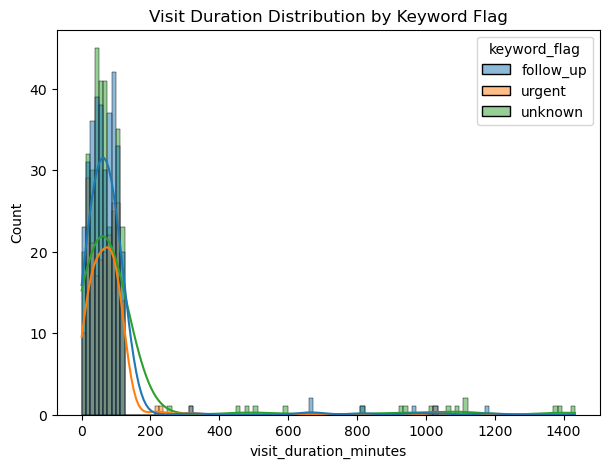

In [41]:
#(Optional, for advanced candidates): 
# Can you infer any insights from the nurse_notes regarding visit outcomes or specific patient needs that might influence visit duration?
print(df2.groupby("keyword_flag")["visit_duration_minutes"].agg(["mean","std","count"]))

# With the limited information available, we can see that when urgency is triggered, the average duration is the shortest, 
# followed by follow-up visits.

# I made the assumption that keywords are generated from customer feedback.
# I set the probability of such feedback triggering an urgency keyword at around 24%. 
# for example, if they are in pain or restless, the visit is marked as urgent. 
# However, urgency is not ranked, ideally we would also check whether this urgency is the highest. 
# Or whether other factors such as customer age, patient history, or service type play a role. 

plt.figure(figsize=(7,5))
sns.histplot(data = df2, x ="visit_duration_minutes", hue= "keyword_flag", kde = True)
plt.title("Visit Duration Distribution by Keyword Flag")

# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_histograms_Keyword.png"),
#             dpi=300, bbox_inches="tight")

plt.show()


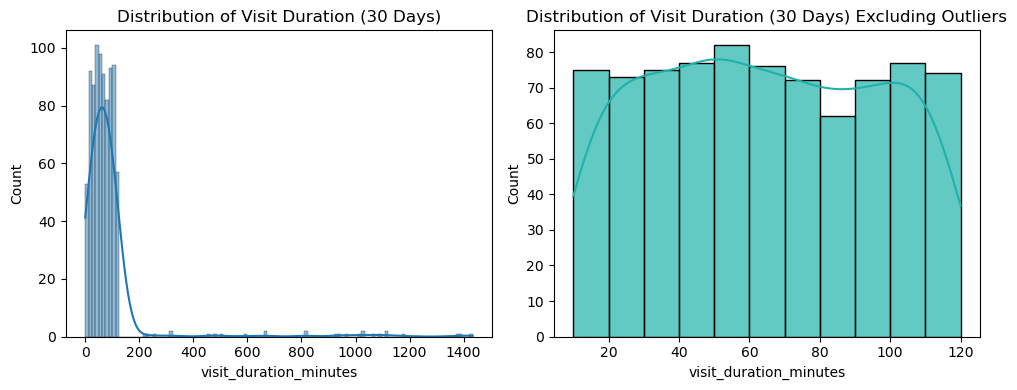

In [42]:
"""Data Visualization"""
#Histograms of visit_duration_minutes.
#The histogram shows that most visits are completed in around 70 minutes, with extreme outliers close to 0 and exceeding 200 minutes.
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df2.loc[:,"visit_duration_minutes"], kde = True, ax = axes[0])
axes[0].set_title("Distribution of Visit Duration (30 Days)")

sns.histplot(df2.loc[df2["duration_outlier"] == 0, "visit_duration_minutes"], kde = True, ax = axes[1],alpha=0.7, color="lightseagreen")
axes[1].set_title("Distribution of Visit Duration (30 Days) Excluding Outliers")
plt.tight_layout()

import os
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_histograms.png"),
#             dpi=300, bbox_inches="tight")

plt.show()

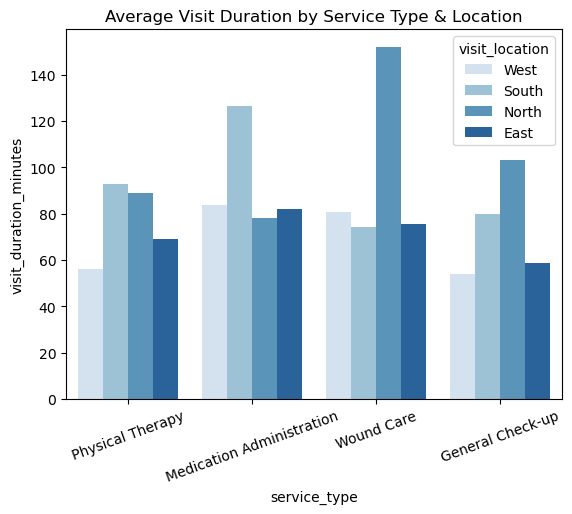

In [43]:
#Bar charts showing average visit duration by service_type and visit_location.v1
# Wound Care in the North has the longest average visit duration.
# General Check-up in the West has the shortest average visit duration.
palette = sns.color_palette("Blues", n_colors=4)

sns.barplot(data=df2, x="service_type", y="visit_duration_minutes", hue="visit_location", errorbar=None,  
            palette=palette)
plt.title("Average Visit Duration by Service Type & Location")
plt.xticks(rotation=20)
plt.show()

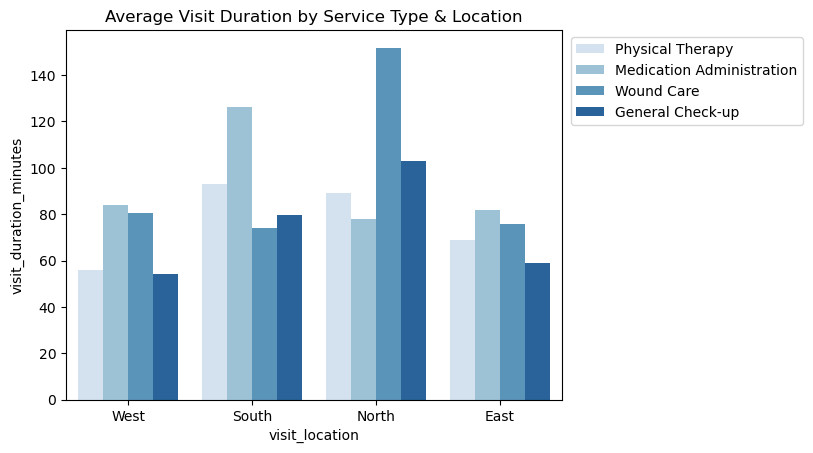

In [44]:
#Bar charts showing average visit duration by service_type and visit_location.v2
# Wound Care in the North has the longest average visit duration.
# General Check-up in the West has the shortest average visit duration.
palette = sns.color_palette("Blues", n_colors=4)
sns.barplot(data=df2, x="visit_location", y="visit_duration_minutes", hue="service_type", errorbar=None, palette = palette)
plt.title("Average Visit Duration by Service Type & Location")
plt.legend(loc="upper right",bbox_to_anchor=(1.5, 1))

# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_barcharts_service_type_and_location.png"),
#             dpi=300, bbox_inches="tight")
plt.show()

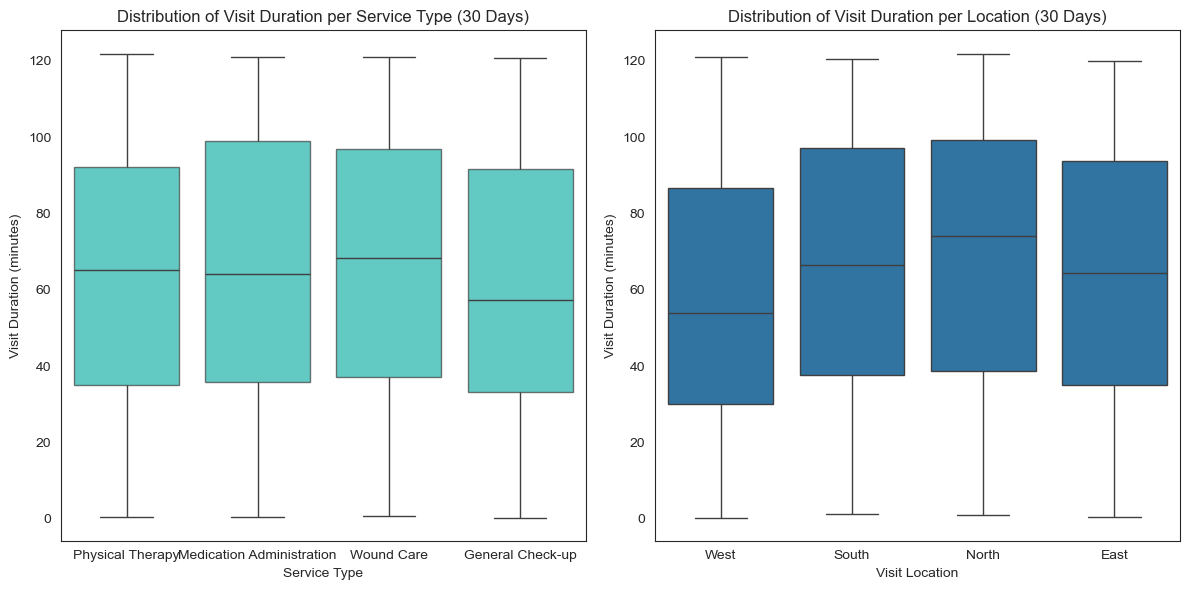

In [45]:
#boxplot to show the distribution of visit durations.
# Excluding outliers, the median visit time is shortest for General Check-up and longest for Wound Care.
# Excluding outliers, patients in the West have the shortest median visit time, whereas patients in the North have the longest.
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = df2, y ="visit_duration_minutes", x = "service_type",ax = axes[0], showfliers = False, 
            boxprops=dict(alpha=0.7, facecolor="lightseagreen"))
axes[0].set_title("Distribution of Visit Duration per Service Type (30 Days)")
axes[0].set_ylabel("Visit Duration (minutes)")   
axes[0].set_xlabel("Service Type")              
sns.boxplot( data = df2, y ="visit_duration_minutes", x = "visit_location",ax = axes[1], showfliers = False)
axes[1].set_title("Distribution of Visit Duration per Location (30 Days)")
axes[1].set_ylabel("Visit Duration (minutes)")   
axes[1].set_xlabel("Visit Location")   
plt.tight_layout()
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_boxplots_service_type_or_location.png"),
#             dpi=300, bbox_inches="tight")
plt.show()

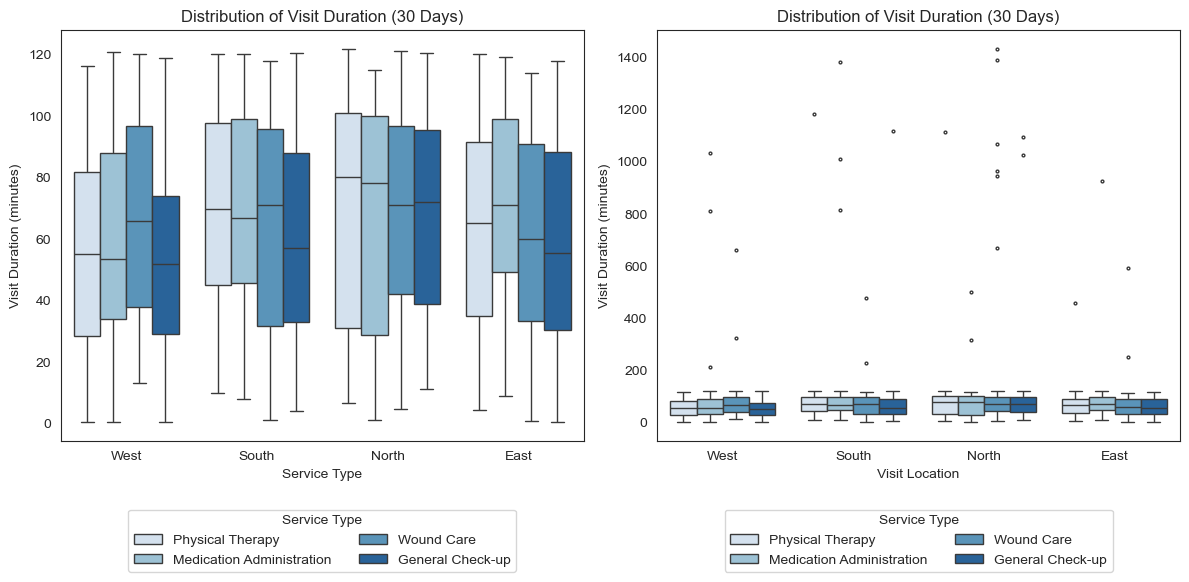

In [46]:
#boxplot to show the distribution of visit durations.

#Wound Care has the longest median duration.
#General Check-up has the shortest median duration.
#Visits in the North are generally the longest.
#Visits in the West are generally the shortest.

# outliers
# Extreme outliers are visible, which distort the boxplots.

palette = sns.color_palette("Blues", n_colors=4)
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = df2, y ="visit_duration_minutes", hue = "service_type",x = "visit_location",ax = axes[0], showfliers = False, palette=palette)
axes[0].set_title("Distribution of Visit Duration (30 Days)")
axes[0].set_ylabel("Visit Duration (minutes)")   
axes[0].set_xlabel("Service Type")              
axes[0].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol = 2, title = "Service Type")
sns.boxplot( data = df2, y ="visit_duration_minutes", hue = "service_type",x = "visit_location",ax = axes[1], fliersize = 2, palette=palette)
axes[1].set_title("Distribution of Visit Duration (30 Days)")
axes[1].set_ylabel("Visit Duration (minutes)")   
axes[1].set_xlabel("Visit Location")   
axes[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol = 2, title = "Service Type")
plt.tight_layout()
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_boxplots_service.png"),
#             dpi=300, bbox_inches="tight")
plt.show()

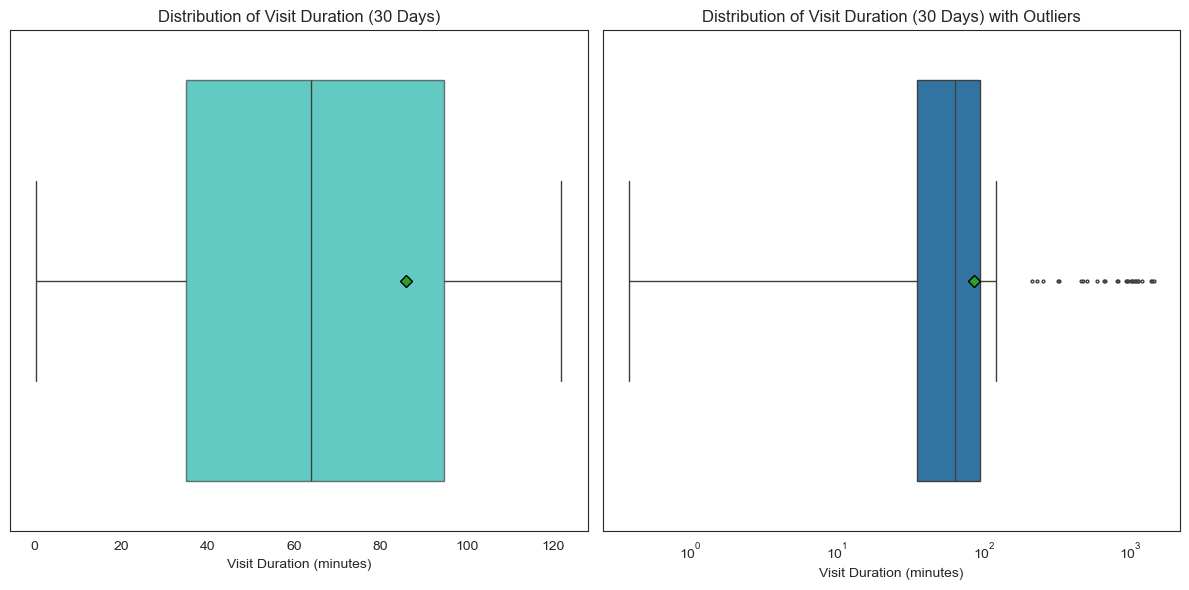

In [47]:
# We use log scale of the duration time to avoid the box is not squashed heavily like the one above.
# Basically we can the mdeian is around 65 mins, average is 90 mins and IQR is around 40-95 mins where majority is.

sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data = df2, x ="visit_duration_minutes",ax = axes[0], showfliers = False, 
            boxprops=dict(alpha=0.7, facecolor="lightseagreen"),
            meanprops={"marker":"D","markeredgecolor":"black"}, showmeans = True)
axes[0].set_title("Distribution of Visit Duration (30 Days)")
axes[0].set_xlabel("Visit Duration (minutes)")              
sns.boxplot( data = df2, x ="visit_duration_minutes",ax = axes[1], fliersize = 2,
            meanprops={"marker":"D","markeredgecolor":"black"}, showmeans = True)
axes[1].set_title("Distribution of Visit Duration (30 Days) with Outliers")
axes[1].set_xlabel("Visit Duration (minutes)")
axes[1].set_xscale("log")
plt.tight_layout()
# save_dir = r"C:\lsrgc\LittleSteps\results"
# plt.savefig(os.path.join(save_dir, "visit_duration_boxplots.png"),
#             dpi=300, bbox_inches="tight")
plt.show()